# Concept
## DB and renew
#### 1. 爬下所有股票代號
### 2. 針對每一支股票代號，每一天往回去爬資料
### 3. 設計表格，爬完後存入 sqlite3
### 4. 設計每日更新報表，比對之前資料，更新上去
### 5. 設計如果前幾天忘記爬的話，會先爬一次
### 6. cronjob跑起來
### 7. 爬財務報表資料
### 8. 設計財報表格，存入 sqlite3

## Analysis
### 1. 布林通道建構

Reference: 
https://medium.com/renee0918/python-%E7%88%AC%E5%8F%96%E5%80%8B%E8%82%A1%E6%AD%B7%E5%B9%B4%E8%82%A1%E5%83%B9%E8%B3%87%E8%A8%8A-b6bc594c8a95

In [1]:
# import package
from datetime import date,timedelta
from urllib.request import urlopen
from dateutil import rrule
import matplotlib.pyplot as plt
import datetime
import requests
import pandas as pd
import numpy as np
import json
import time
from io import StringIO

%matplotlib inline

In [96]:
# 爬取每月股價的目標網站並包裝成函式
def craw_one_month(stock_number,date):
    url = (
        "http://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+
        date.strftime('%Y%m%d')+
        "&stockNo="+
        str(stock_number)
    )
    data = json.loads(urlopen(url).read())
    return pd.DataFrame(data['data'],columns=data['fields'])

# 根據使用者輸入的日期，以月為單位，重複呼叫爬取月股價的函式
def craw_stock(stock_number, start_month):
    b_month = date(*[int(x) for x in start_month.split('-')])
    now = datetime.datetime.now().strftime("%Y-%m-%d")         # 取得現在時間
    e_month = date(*[int(x) for x in now.split('-')])
    
    result = pd.DataFrame()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=b_month, until=e_month):
        result = pd.concat([result,craw_one_month(stock_number,dt)],ignore_index=True)
        time.sleep(2000.0/1000.0);
    return result

def get_IPO_list():
    res = requests.get("http://isin.twse.com.tw/isin/C_public.jsp?strMode=2")
    df = pd.read_html(res.text)[0]
    # 設定column名稱
    df.columns = pd.Series(['name', 'ISIN_Code', 'start_day', 'category', 'industry', 'CFICode', 'note']) 
    df = df.iloc[1:] # 刪除第一行
    df = df.dropna(thresh=3, axis=0).dropna(thresh=3, axis=1) # 先移除row，再移除column，超過三個NaN則移除
    df["No"] = df["name"].str.split("　", n = 1, expand = True).iloc[:,[0]]
    df["name"] = df["name"].str.split("　", n = 1, expand = True).iloc[:,[1]]
    df = df.set_index('No')
    indexNames = df[df['ISIN_Code'] == df['start_day']].index
    df.drop(indexNames , inplace=True)
    df.to_csv("IPO_list.csv", header = True)
    return df


def get_OTC_list():
    res = requests.get("http://isin.twse.com.tw/isin/C_public.jsp?strMode=4")
    df = pd.read_html(res.text)[0]
    # 設定column名稱
    df.columns = pd.Series(['name', 'ISIN_Code', 'start_day', 'category', 'industry', 'CFICode', 'note']) 
    df = df.iloc[1:] # 刪除第一行
    df = df.dropna(thresh=3, axis=0).dropna(thresh=3, axis=1) # 先移除row，再移除column，超過三個NaN則移除
    df["No"] = df["name"].str.split("　", n = 1, expand = True).iloc[:,[0]]
    df["name"] = df["name"].str.split("　", n = 1, expand = True).iloc[:,[1]]
    df = df.set_index('No')
    indexNames = df[df['ISIN_Code'] == df['start_day']].index
    df.drop(indexNames , inplace=True)
    df.to_csv("OTC_list.csv", header = True)
    return df

In [17]:
start_month = "2019-01-01"
stock_number = 2330
b_month = date(*[int(x) for x in start_month.split('-')])
now = datetime.datetime.now().strftime("%Y-%m-%d")         # 取得現在時間
e_month = date(*[int(x) for x in now.split('-')])
print(b_month)
print(now)
print(e_month)
result = pd.DataFrame()

2019-01-01
2019-09-15
2019-09-15


In [19]:
 for dt in rrule.rrule(rrule.MONTHLY, dtstart=b_month, until=e_month):
        print(dt)

2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00


In [20]:
df = craw_stock(2330,"2019-01-01")
df.set_index("日期", inplace=True)

In [21]:
df

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
108/01/02,"32,900,482","7,276,419,230",226.50,226.50,219.00,219.50,-6.00,"12,329"
108/01/03,"34,615,620","7,459,051,790",214.00,218.00,214.00,215.50,-4.00,"14,549"
108/01/04,"67,043,521","13,987,136,785",211.50,211.50,206.50,208.00,-7.50,"28,786"
108/01/07,"35,695,176","7,591,116,569",212.00,214.00,211.00,213.00,+5.00,"11,224"
108/01/08,"23,794,481","5,019,703,557",212.00,212.50,210.00,211.00,-2.00,"9,377"
108/01/09,"51,255,446","11,006,827,093",212.00,216.50,211.00,215.50,+4.50,"14,098"
108/01/10,"20,832,593","4,491,377,349",216.00,216.50,214.50,216.00,+0.50,"6,018"
108/01/11,"28,658,288","6,296,719,320",219.00,220.50,218.00,220.50,+4.50,"11,198"
108/01/14,"17,612,296","3,844,735,324",218.50,220.00,217.00,218.50,-2.00,"6,469"


Text(0, 0.5, 'stock')

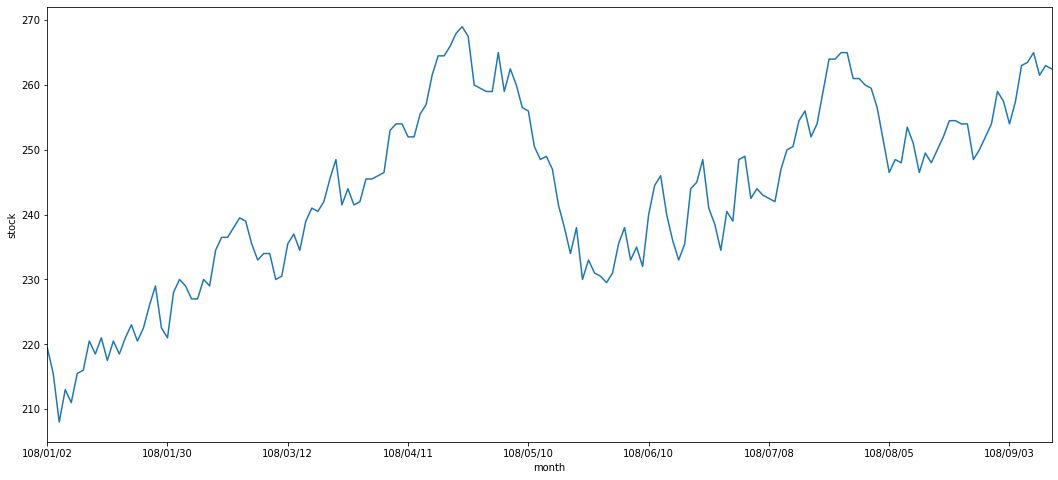

In [22]:
# 將爬取到的歷年股價資訊繪成圖表
df['收盤價']=df['收盤價'].astype(float)
df.loc[:]['收盤價'].plot(figsize=(18, 8))
plt.xlabel('month')
plt.ylabel('stock')

In [98]:
#IPO_df = get_IPO_list()
IPO_df.head()

,name,ISIN_Code,start_day,category,industry,CFICode,note
No,,,,,,,
1101,台泥,TW0001101004,1962/02/09,上市,水泥工業,ESVUFR,NaN
1102,亞泥,TW0001102002,1962/06/08,上市,水泥工業,ESVUFR,NaN
1103,嘉泥,TW0001103000,1969/11/14,上市,水泥工業,ESVUFR,NaN
1104,環泥,TW0001104008,1971/02/01,上市,水泥工業,ESVUFR,NaN
1108,幸福,TW0001108009,1990/06/06,上市,水泥工業,ESVUFR,NaN


In [99]:
OTC_df = get_OTC_list()
OTC_df.head()

,name,ISIN_Code,start_day,category,industry,CFICode,note
No,,,,,,,
70005X,精華元大66展02,TW16Z70005X5,2016/12/19,上櫃,NaN,RWSCCE,NaN
70006X,良維元大6C展02,TW17Z70006X2,2017/06/19,上櫃,NaN,RWSCCE,NaN
700576,三貝德凱基8A購01,TW18Z7005762,2018/10/19,上櫃,NaN,RWSCCA,NaN
700577,大中凱基8A購01,TW18Z7005770,2018/10/19,上櫃,NaN,RWSCCA,NaN
700587,碩禾凱基8A購01,TW18Z7005879,2018/10/19,上櫃,NaN,RWSCCA,NaN


In [81]:
import datetime
time = datetime.datetime.now()
date_str = '{0}{1:02d}{2:02d}'.format(time.year, time.month, time.day)
print(date_str)
time -= timedelta(1)
date_str = '{0}{1:02d}{2:02d}'.format(time.year, time.month, time.day)
print(date_str)

20190922
20190921


In [246]:
date_str = '108/09/17'
r = requests.get("https://www.tpex.org.tw/web/stock/aftertrading/daily_close_quotes/stk_quote_result.php?l=zh-tw&d=" + date_str)  
content = r.json()
print(content)

{'reportDate': '108/09/17', 'reportTitle': '上櫃股票行情(含等價、零股、盤後、鉅額交易)', 'iTotalRecords': 4834, 'iTotalDisplayRecords': 4834, 'listNum': '774', 'totalAmount': '30,537,175,358', 'totalVolumn': '414,856,775', 'totalCount': '244,375', 'mmData': [['4415', '台原藥', '4.19', '+0.31', '3.88', '4.19', '3.88', '3.94', '4,999', '19,699', '10', '3.75', '4.20', '43,577,168', '4.19', '4.60', '3.78']], 'aaData': [['006201', '元大富櫃50', '13.11', '-0.01 ', '13.12', '13.17', '13.10', '13.13', '97,227', '1,276,458', '42', '13.11', '13.12', '29,446,000', '13.11', '14.42', '11.80'], ['00679B', '元大美債20年', '44.15', '-0.42 ', '44.19', '44.19', '44.06', '43.85', '70,345,906', '3,084,638,830', '733', '44.15', '44.16', '766,192,000', '44.15', '9999.95', '0.01'], ['00687B', '國泰20年美債', '45.90', '+0.25', '45.97', '46.01', '45.90', '45.96', '318,000', '14,616,020', '58', '45.90', '45.92', '416,287,000', '45.90', '9999.95', '0.01'], ['00694B', '富邦美債1-3', '41.24', '-0.03 ', '41.27', '41.30', '41.24', '41.27', '602,000', '24,8

In [218]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import datetime

# time = datetime.datetime.now()
# datestr = '{0}{1:02d}{2:02d}'.format(time.year, time.month, time.day)
datestr = '20180131'

# 下載股價
r = requests.post('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALL')

# 整理資料，變成表格
df = pd.read_csv(StringIO(r.text.replace("=", "")), header=["證券代號" in l for l in r.text.split("\n")].index(True)-1).iloc[:,range(0,16)]

# 整理一些字串：
df.iloc[:,range(2,16)] = df.iloc[:,range(2,16)].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "").replace("+", "1").replace("-", "-1"), errors='coerce'))
df.iloc[:,9] = (df.iloc[:,9] * df.iloc[:,10])*100 / (df.iloc[:,8] - df.iloc[:,9] * df.iloc[:,10])
df.rename(columns={'漲跌(+/-)':'漲跌比例'}, inplace=True)
df = df.round({'漲跌比例':2}) 
df['日期'] = pd.Series([datestr]*df.shape[0])
# 顯示出來
df

,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌比例,漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,日期
0,0050,元大台灣50,4251739,1176,359040915,84.40,85.00,84.15,84.65,0.12,0.10,84.60,21,84.65,80,0.00,20180131
1,0051,元大中型100,7500,3,243040,32.39,32.39,32.39,32.39,0.28,0.09,32.39,43,32.50,5,0.00,20180131
2,0052,富邦科技,4001,5,229706,57.35,57.60,57.30,57.40,0.09,0.05,57.35,1,57.90,1,0.00,20180131
3,0053,元大電子,1,1,37,NaN,NaN,NaN,NaN,NaN,0.00,37.09,50,37.35,1,0.00,20180131
4,0054,元大台商50,2001,3,48904,24.44,24.44,24.44,24.44,-0.20,0.05,24.41,50,24.64,8,0.00,20180131
5,0055,元大MSCI金融,89001,31,1500207,16.79,16.92,16.79,16.92,0.18,0.03,16.93,52,16.95,1,0.00,20180131
6,0056,元大高股息,2438996,744,64241193,26.30,26.48,26.17,26.45,0.15,0.04,26.45,5,26.46,20,0.00,20180131
7,0057,富邦摩台,0,0,0,NaN,NaN,NaN,NaN,NaN,0.00,51.60,1,51.85,20,0.00,20180131
8,0058,富邦發達,0,0,0,NaN,NaN,NaN,NaN,NaN,0.00,46.54,21,46.97,21,0.00,20180131
9,0059,富邦金融,2001,3,83361,41.73,41.73,41.59,41.59,-1.21,0.51,41.80,1,42.20,1,0.00,20180131


In [219]:
import sqlite3
import os
import pandas as pd
from datetime import datetime
from pandas.io import sql

conn = sqlite3.connect('stock_analytics.db')

### 設計股票基本數據儲存表格
schema         | Type       | 中文     
---------------|------------|-----------
stock_id       | TEXT       | 證券代號
stock_name     | TEXT       | 證券名稱
date           | TEXT       | 日期
volume         | INT        | 成交股數
transactions   | INT        | 成交筆數
turnover_value | INT        | 成交金額
open           | REAL       | 開盤價  
high           | REAL       | 最高價  
low            | REAL       | 最低價  
close          | REAL       | 收盤價  
change_ratio   | REAL       | 漲跌比例
spread         | REAL       | 漲跌價差
last_bid_price | REAL       | 最後揭示買價
last_bid_volumn| REAL       | 最後揭示買量
last_ask_price | REAL       | 最後揭示賣價
last_ask_volumn| REAL       | 最後揭示賣量
PE_ratio       | REAL       | 本益比


In [221]:
conn.execute(
    '''CREATE TABLE STOCK_DAILY
       (ID INTEGER PRIMARY KEY   AUTOINCREMENT,
        stock_id        TEXT  NOT NULL,
        stock_name      TEXT,
        date            TEXT  NOT NULL,
        volume          INT,
        transactions    INT,
        turnover_value  INT,
        open            REAL,
        high            REAL,
        low             REAL,
        close           REAL,
        change_ratio    REAL,
        spread          REAL,
        last_bid_price  REAL,
        last_bid_volumn REAL,
        last_ask_price  REAL,
        last_ask_volumn REAL,
        PE_ratio        REAL,
        Timestamp DATETIME DEFAULT CURRENT_TIMESTAMP);''')


OperationalError: table STOCK_DAILY already exists

In [124]:
for index, row in df[0:10].iterrows():
    list_item = row.tolist()
    sql_str = "INSERT INTO STOCK_DAILY (stock_id, stock_name, date, volume, transactions, turnover_value, open, high, low, close, change_ratio, spread, last_bid_price, last_bid_volumn, last_ask_price, last_ask_volumn, PE_ratio) VALUES( '" +str(list_item[0]) + "','" + str(list_item[1]) + "','" +datestr + "'," +str(list_item[2]) + ',' +str(list_item[3]) + ',' +str(list_item[4]) + ',' +str(list_item[5]) + ',' +str(list_item[6]) + ',' +str(list_item[7]) + ',' +str(list_item[8]) + ',' +str(list_item[9]) + ',' +str(list_item[10]) + ',' +str(list_item[11]) + ',' +str(list_item[12]) + ',' +str(list_item[13]) + ',' +str(list_item[14]) + ',' +str(list_item[15]) + ")"
    conn.execute(sql_str)
conn.commit()

OperationalError: no such column: nan

In [174]:
for index, row in df[0:1].iterrows():
    list_item = row.to_dict()
    print(list_item)
    sql_str = '''INSERT INTO STOCK_DAILY 
                    (stock_id, stock_name, date, volume, transactions, turnover_value, 
                     open, high, low, close, change_ratio, spread, 
                     last_bid_price, last_bid_volumn, last_ask_price, last_ask_volumn, PE_ratio) 
                    VALUES
                    ('{證券代號}', '{證券名稱}', '{日期}', {成交股數}, {成交筆數}, {成交金額}, 
                      {開盤價}, {最高價}, {最低價}, {收盤價}, {漲跌比例}, {漲跌價差},
                      {最後揭示買價}, {最後揭示買量}, {最後揭示賣價}, {最後揭示賣量}, {本益比})'''.format(**list_item)     
    print(sql_str)
    conn.execute(sql_str)
conn.commit()

{'證券代號': '0050', '證券名稱': '元大台灣50', '成交股數': 4251739, '成交筆數': 1176, '成交金額': 359040915, '開盤價': 84.4, '最高價': 85.0, '最低價': 84.15, '收盤價': 84.65, '漲跌比例': 0.12, '漲跌價差': 0.1, '最後揭示買價': 84.6, '最後揭示買量': 21, '最後揭示賣價': 84.65, '最後揭示賣量': 80, '本益比': 0.0, '日期': '20180131'}
INSERT INTO STOCK_DAILY 
                    (stock_id, stock_name, date, volume, transactions, turnover_value, 
                     open, high, low, close, change_ratio, spread, 
                     last_bid_price, last_bid_volumn, last_ask_price, last_ask_volumn, PE_ratio) 
                    VALUES
                    ('0050', '元大台灣50', '20180131', 4251739, 1176, 359040915, 
                      84.4, 85.0, 84.15, 84.65, 0.12, 0.1,
                      84.6, 21, 84.65, 80, 0.0)


OperationalError: database is locked

In [222]:
df.rename(columns={'證券代號':'stock_id',
                    '證券名稱':'stock_name',
                    '日期':'date',
                    '成交股數':'volume',
                    '成交筆數':'transactions',
                    '成交金額':'turnover_value',
                    '開盤價':'open',
                    '最高價':'high',
                    '最低價':'low',
                    '收盤價':'close',
                    '漲跌比例':'change_ratio',
                    '漲跌價差':'spread',
                    '最後揭示買價':'last_bid_price',
                    '最後揭示買量':'last_bid_volumn',
                    '最後揭示賣價':'last_ask_price',
                    '最後揭示賣量':'last_ask_volumn',
                    '本益比':'PE_ratio'}, 
                    inplace=True)
#df.set_index('date',inplace=True)
sql.to_sql(df, name='STOCK_DAILY', con=conn, if_exists='append')

In [211]:
#conn.commit()


In [235]:
time.time()

datetime.time(10, 59, 9, 985682)

In [231]:
date_str = '{0}/{1:02d}/{2:02d}'.format(2018, 1, 12)